# **PROJECT ACCIDENTOLOGIE : KAGGLE ESIEE 2023 - 2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_columns', None)

# **OPENING FILES**

In [3]:
def open_file(item):
    # Création d'un DataFrame vide pour accumuler les données
    all_data = pd.DataFrame()

    # Boucle sur chaque année
    for annee in range(2012, 2023):
        path = f"TRAIN/BAAC-Annee-{annee}/{item}_{annee}_.csv"
        try:
            # Lecture du fichier CSV
            file = pd.read_csv(path, delimiter=';', index_col = 0,low_memory=False)
            # Concaténation du fichier lu avec le DataFrame global
            all_data = pd.concat([all_data, file])
        except FileNotFoundError:
            print(f"Le fichier {path} n'a pas été trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {path}: {e}")

    return all_data

In [4]:
def create_dataframe():

    caracteristiques = open_file('caracteristiques')
    lieux = open_file('lieux')
    usagers = open_file('usagers')
    vehicules = open_file('vehicules')

    return caracteristiques,lieux,usagers,vehicules

In [5]:
caracteristiques,lieux,usagers,vehicules = create_dataframe()

### **Isolation de la colonne Grave**

In [6]:
# Convertir la colonne 'grav' en array numpy
grav_array = usagers['grav'].values
num_acc_array = usagers['Num_Acc'].values

# Créer un array pour la présence de 'GRAVE'
is_grave = np.isin(grav_array, [2, 3])

# Utiliser ufuncs de numpy pour créer un mapping de 'Num_Acc' à 'GRAVE'
unique_nums, grave_presence = np.unique(num_acc_array, return_inverse=True)
result = np.bitwise_or.reduceat(is_grave, np.r_[0, np.where(np.diff(num_acc_array))[0]+1])

In [7]:
usagers.drop('grav',axis = 1,inplace = True)

In [8]:
# Création du DataFrame
df_grave = pd.DataFrame({
    'Num_Acc': unique_nums,
    'GRAVE': result
})

df_grave['GRAVE'] = df_grave['GRAVE'].astype(int)

### **Merge GRAVE + Dataframe :** 

In [9]:
def merge_grave(df):

    return df_grave.merge(df,on = "Num_Acc",how = 'left')

### **Fonction Analyse :**

In [10]:
def summary_info(df):

    # Créer un nouveau DataFrame avec ces comptages
    return  pd.DataFrame({
        'NaN_Count': df.isna().sum().astype(int),
        'Nan_ratio': df.isna().mean().astype(float),
        '-1_Count': df.eq(-1).sum().astype(int),
        '0_Count': df.eq(0).sum().astype(int)
    })

### **Fonction Aggregation :**

In [11]:
def column_aggreg(df,column):

    # One-hot encoding sur la colonne "trajet"
    one_hot_trajet = pd.get_dummies(df[column], prefix= column)

    # Ajouter la colonne Num_Acc pour pouvoir fusionner les résultats plus tard
    one_hot_trajet['Num_Acc'] = df['Num_Acc']

    # Aggrégation des résultats pour chaque accident
    one_hot_trajet_grouped = one_hot_trajet.groupby('Num_Acc').sum().reset_index()

    # Fusionner ces résultats avec ton DataFrame initial
    df = pd.merge(df, one_hot_trajet_grouped, on='Num_Acc', how='left')

    return df

# **USAGERS :**

## **PREPROCESSING :**

In [12]:
def usagers_del_(df):

    col_to_drop = ['id_vehicule','id_usager','secu2','secu3','actp']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [13]:
def usagers_NaN_(df):

    col_to_replace = ['place','trajet']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [14]:
def usagers_correction_(df):

    df['locp'] = df['locp'].replace(9,-1)
    df['trajet'] = df['trajet'].replace(0,-1)

    # Calcul de la médiane en excluant les NaN
    median_an_nais = df['an_nais'].median()

    # Remplacement des NaN par la médiane dans la colonne 'an_nais'
    df['an_nais'].fillna(median_an_nais, inplace=True)

    return df

In [15]:
def pieton_correction_(df):

     # Remplacement conditionnel des valeurs
    condition_3 = (df['catu'] == 3) & df['locp'].isna() & df['etatp'].isna()

    # Condition pour catu != 3 et toutes les valeurs pertinentes sont NaN
    condition_not_3 = (df['catu'] != 3) & df['locp'].isna() & df['etatp'].isna()

    # Appliquer les conditions pour les trois colonnes
    df.loc[condition_3, ['locp', 'etatp']] = -1
    df.loc[condition_not_3, ['locp', 'etatp']] = 0

    col_to_replace = ['locp','etatp']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)

    return df

In [16]:
def adjust_secu(value):
    if value in [1, 2, 3, 4, 9]:
        return -1
    elif value >= 10:
        tens = int(value // 10)
        units = int(value % 10)
        if units == 1:
            return tens
        elif units == 3:
            return 3
        elif units == 2:
            return 0
        else:
            return value  # Si aucune des autres conditions n'est rencontrée, renvoyer la valeur originale
    else:
        return value  # Pour les cas négatifs et autres cas non définis

def merge_columns(df):
    
    df['secu'] = df['secu'].fillna(df['secu1'])
    df['secu'] = df['secu'].replace([9,4,6,5,7],0)
    df['secu'] = df['secu'].fillna(-1)
    df.drop(['secu1'],axis = 1,inplace= True)
    
    return df

In [17]:
def usagers_preprocessing_(df):

    df = usagers_del_(df)
    df = usagers_NaN_(df)
    df = pieton_correction_(df)
    df = usagers_correction_(df)

    df['secu'] = df['secu'].apply(adjust_secu)
    df = merge_columns(df)

    cols_to_convert_category = ['place','catu','sexe','trajet','secu','locp','etatp','num_veh']

    df[cols_to_convert_category] = df[cols_to_convert_category].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [18]:
def create_age(df):

    # Calcul de la médiane pour la colonne 'an_nais' en ignorant les valeurs NaN
    median_an_nais = df['an_nais'].median()

    # Remplacement des NaN par la médiane dans la colonne 'an_nais'
    df['an_nais'].fillna(median_an_nais, inplace=True)

    
    df['an_nais'] = df['an_nais'].astype(int)
    df['age'] = df['Num_Acc'].astype(str).str[:4].astype(int) - df['an_nais']

    df['age'] = df['age'].astype(int)
    
    return df

In [19]:
def create_catu(df):

    df['total_usagers'] = df.groupby('Num_Acc')['Num_Acc'].transform('count')
    
    df['nb_conducteurs'] = df['catu'].eq(1).groupby(df['Num_Acc']).transform('sum').astype(int)
    df['nb_passagers'] = df['catu'].eq(2).groupby(df['Num_Acc']).transform('sum').astype(int)

    df['ratio_conducteurs'] = df['nb_conducteurs'] / df['total_usagers']
    df['ratio_passagers'] = df['nb_passagers'] / df['total_usagers']
    
    return df

In [20]:
def secu_catu(df):

    # 1. Groupby sur la colonne "Num_Acc" et compter les conducteurs avec ceinture
    nombre_conducteur_avec_ceinture = df[df['secu'] == 1 & (df['catu'] == 1)].groupby('Num_Acc').size().reset_index(name='nombre_conducteur_avec_ceinture')

    # 2. Fusionner les résultats avec ton DataFrame initial
    df = pd.merge(df, nombre_conducteur_avec_ceinture, on='Num_Acc', how='left')

    # 1. Groupby sur la colonne "Num_Acc" et compter les conducteurs avec ceinture
    nombre_passager_avec_ceinture = df[df['secu'] == 1 & (df['catu'] == 2)].groupby('Num_Acc').size().reset_index(name='nombre_passagers_avec_ceinture')

    # 2. Fusionner les résultats avec ton DataFrame initial
    df = pd.merge(df, nombre_passager_avec_ceinture, on='Num_Acc', how='left')

    df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']] = df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']].fillna(0)

    return df

In [21]:
def count_sexe(df):
    # Grouper par 'Num_Acc' et compter les occurrences de chaque sexe
    count_sexe = df.groupby('Num_Acc')['sexe'].value_counts().unstack(fill_value=0)

    # Renommer les colonnes pour plus de clarté
    count_sexe.columns = ['nb_hommes', 'nb_femmes','nb_inconnue']

    # Rejoindre avec le DataFrame original
    return df.merge(count_sexe, left_on='Num_Acc', right_index=True)

In [22]:
def age_annais(df):

    # Groupby Num_Acc et calcul des moyennes
    grouped = df.groupby('Num_Acc')
    mean_age = grouped['age'].mean()
    mean_an_nais = grouped['an_nais'].mean()

    # Création de nouvelles colonnes dans le DataFrame original pour les moyennes
    df['age'] = df['Num_Acc'].map(mean_age)
    df['an_nais'] = df['Num_Acc'].map(mean_an_nais)
    
    return df

In [23]:
def feature_engineering_usagers(df):

    df = usagers_preprocessing_(df)

    df = create_age(df)
    df = create_catu(df)
    df = secu_catu(df)
    df = count_sexe(df)
    #df = column_aggreg(df,'secu')
    #df = column_aggreg(df,'trajet')
    #df = column_aggreg(df,'place')
    #df = column_aggreg(df,'locp')
    #df = column_aggreg(df,'etatp')
    
    #df = age_annais(df)

    col_to_drop = ['secu','trajet','place','sexe','locp','etatp','num_veh','catu','nb_inconnue']

    df[col_to_drop] = df[col_to_drop].astype('category')

    #df = df.drop(col_to_drop,axis = 1)

    #df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

# **VEHICULES :**

## **PREPROCESSING :**

In [24]:
def vehicules_del_(df):

    col_to_drop = ['id_vehicule','occutc']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [25]:
def vehicules_NaN_(df):

    col_to_replace = ['senc','catv','obs','obsm','choc','manv','motor']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [26]:
def vehicules_correction_(df):

    cols_to_replace = ['senc','catv','choc','manv','motor']
    df[cols_to_replace] = df[cols_to_replace].replace(0,-1)

    return df

In [27]:
def vehicules_preprocessing_(df):

    df = vehicules_del_(df)
    df = vehicules_NaN_(df)
    df = vehicules_correction_(df)

    cols_to_convert = ['senc','catv','obs','obsm','choc','manv','motor']
    df[cols_to_convert] = df[cols_to_convert].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [28]:
def catv_category(df):

    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    set_vl = {7, 8, 9, 10, 11, 12}

    set_pl = {13, 14, 15}

    set_edp = {50, 50, 80}

    def check_moto_vl(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_vl(catv_set):
        return 1 if (set_pl.intersection(catv_set) and set_vl.intersection(catv_set)) else 0
    
    def check_pl_moto(catv_set):
        return 1 if (set_moto.intersection(catv_set) and set_pl.intersection(catv_set)) else 0
    
    # Grouper par 'Num_Acc' et appliquer set() sur 'catv'
    grouped = df.groupby('Num_Acc')['catv'].apply(set)

    # Créer une colonne 'Accident_Voiture' initialisée à 0
    df['Accident_Moto_Voiture'] = 0
    df['Accident_Moto_Camion'] = 0
    df['Accident_Voiture_Camion'] = 0

    df['Accident_Moto_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_moto))
    df['Accident_Voiture_Camion'] = df['Num_Acc'].map(grouped.apply(check_pl_vl))
    df['Accident_Moto_Voiture'] = df['Num_Acc'].map(grouped.apply(check_moto_vl))
    
    return df

In [29]:
def manv_catv(df):
    
    set_moto = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Création des colonnes indiquant les accidents spécifiques
    df['Accident_Moto_Gauche'] = ((df['manv'] == 17) & df['catv'].isin(set_moto)).astype(int)

    return df

In [30]:
def obsm_pieton(df):
    set_vl_pieton = {7, 8, 9, 10, 11, 12}
    set_pl_pieton = {13, 14, 15, 37, 38, 39, 40}
    set_vl = {1, 2, 3, 4, 5, 6, 30, 31, 32, 33, 34}

    # Conditions pour chaque type de collision
    df['Colision_Voiture_Pieton'] = ((df['catv'].isin(set_vl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_PL_Pieton'] = ((df['catv'].isin(set_pl_pieton)) & (df['obsm'] == 1)).astype(int)
    df['Colision_VL_Pieton'] = ((df['catv'].isin(set_vl)) & (df['obsm'] == 1)).astype(int)

    df['Colision_Voiture_Pieton'] = df.groupby('Num_Acc')['Colision_Voiture_Pieton'].transform('max')
    df['Colision_PL_Pieton'] = df.groupby('Num_Acc')['Colision_PL_Pieton'].transform('max')
    df['Colision_VL_Pieton'] = df.groupby('Num_Acc')['Colision_VL_Pieton'].transform('max')

    return df

In [31]:
def collison_frontale(df):

    def collision_frontale_verif(choc_set):
        target_set = {1, 2, 3}
        # Trouver l'intersection du set de choc et du set cible
        intersection = choc_set.intersection(target_set)
        # Retourner 1 si au moins deux éléments distincts sont trouvés
        return 1 if len(intersection) >= 2 else 0


    grouped_choc = df.groupby('Num_Acc')['choc'].apply(set)

    df['Collision_Frontale'] = df['Num_Acc'].map(grouped_choc.apply(collision_frontale_verif))

    return df

In [32]:
def feature_engineering_vehicules(df):

    df = vehicules_preprocessing_(df)
    df = catv_category(df)
    df = manv_catv(df)
    df = obsm_pieton(df)
    df = collison_frontale(df)

    #df = column_aggreg(df,'manv')
    #df = column_aggreg(df,'obs')
    #df = column_aggreg(df,'obsm')
    #df = column_aggreg(df,'catv')
    #df = column_aggreg(df,'choc')
    #df = column_aggreg(df,'motor')

    col_to_drop = ['manv','obs','obsm','catv','choc','motor','num_veh']

    df[col_to_drop] = df[col_to_drop].astype('category')
    
    #df = df.drop(col_to_drop,axis = 1)

    #df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

# **CARACTERISTIQUES :**

## **PREPROCESSING :**

In [33]:
def caracteristiques_del_(df):

    col_to_drop = ['adr','lat','long']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [34]:
def caracteristiques_NaN_(df):

    col_to_replace = ['atm','col','gps']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [35]:
def caracteristiques_correction_(df):

    df['int'] = df['int'].replace(0,-1)

    return df

In [36]:
def adjust_year(year):
    if year < 100:  # Supposons que toute valeur < 100 représente les deux derniers chiffres de l'année
        return 2000 + year
    else:
        return year

In [37]:
def convert_time_to_minutes(time_str):
    # S'assurer que toutes les entrées sont des chaînes de caractères
    time_str = str(time_str)
    
    if ':' in time_str:  # Format HH:MM
        hours, minutes = map(str, time_str.split(':'))
        return int(hours + minutes)
    else:  # Format en nombre entier représentant des minutes ou des horaires comme '1800' qui signifie 18:00
        time_str = time_str.zfill(4)  # Assure que la chaîne a au moins 4 caractères (par ex. '533' devient '0533')
        hours = str(time_str[:2])
        minutes = str(time_str[2:])
        return int(hours + minutes)
    
def processing_hrmn(df):

    df['hrmn'] = df['hrmn'].apply(convert_time_to_minutes)
    df['hrmn'] = df['hrmn'].apply(lambda x: round(x / 100) * 100)

    return df

In [38]:
def clean_dep(dep, an):
    if an <= 2018 and dep not in [201, 202, 972, 973, 974, 976]:
        return int(dep) // 10

    return dep

def preprocessing_dep(df):

    df['dep'] = df['dep'].replace('2B',201)
    df['dep'] = df['dep'].replace('2A',202)
    df['dep'] = df.apply(lambda row: clean_dep(row['dep'], row['an']), axis=1)

    return df

In [39]:
def caracteristiques_preprocessing_(df):

    df = caracteristiques_del_(df)
    df = caracteristiques_NaN_(df)
    df = caracteristiques_correction_(df)

    df['an'] = df['an'].apply(adjust_year)
    df = processing_hrmn(df)
    df = preprocessing_dep(df)

    category_columns = ['lum','agg','int','atm','col','dep']
    df[['an','jour','mois','hrmn']] = df[['an','jour','mois','hrmn']].astype(int)
    df[category_columns] = df[category_columns].astype(int)

    category_columns.append('gps')
    category_columns.append('com')

    df[category_columns] = df[category_columns].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [40]:
def feature_engineering_caracteristiques(df):

    df = caracteristiques_preprocessing_(df)
    
    return df

# **LIEUX :**

In [41]:
def lieux_del_(df):

    col_to_drop = ['voie','lartpc']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [42]:
def lieux_NaN_(df):

    col_to_replace = ['circ','vosp','prof','plan','larrout','surf','infra','situ','vma','env1','pr','pr1','v1','v2']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [43]:
def lieux_correction_(df):

    df['nbv'] = df['nbv'].replace("#ERREUR",-1)
    df['nbv'] = df['nbv'].replace(" -1",-1)
    df['nbv'] = df['nbv'].fillna(-1)
    df['nbv'] = df['nbv'].astype(int)

    cols_to_replace = ['nbv']

    cols_to_replace = ['surf']

    df[cols_to_replace] = df[cols_to_replace].replace(0,-1)

    return df

In [44]:
def modif_larrout(df):

    df['larrout'] = df['larrout'].astype(str)
    df['larrout'] = df['larrout'].str.replace(',', '.').str.strip()
    df['larrout'] = df['larrout'].str.replace(" -1", "-1")
    df['larrout'] = df['larrout'].astype(float)
    df['larrout'] = np.where(df['larrout'] > 1, np.ceil(df['larrout'] / 100), df['larrout'])
    df['larrout'] = np.where(df['larrout'] > 2, 2, df['larrout'])
    
    return df

In [45]:
def lieux_preprocessing_(df):

    df = lieux_del_(df)
    df = lieux_NaN_(df)
    df = lieux_correction_(df)

    df = modif_larrout(df)

    column = ['catr','circ','vosp','prof','plan','surf','infra','situ','larrout']
    df[column] = df[column].astype(int)

    column = ['catr','circ','vosp','prof','plan','surf','infra','situ','env1','vma','pr','pr1','v1','v2']

    df[column] = df[column].astype('category')

    return df

## **FEATURE ENGINEERING :**

In [46]:
def feature_engineering_lieux(df):

    df = lieux_preprocessing_(df)

    return df

# **TRAINING MODEL :**

In [47]:
usagers = feature_engineering_usagers(usagers)

In [48]:
vehicules = feature_engineering_vehicules(vehicules)

In [49]:
caracteristiques = feature_engineering_caracteristiques(caracteristiques)

In [50]:
lieux = feature_engineering_lieux(lieux)

In [51]:
df = usagers.merge(vehicules,on = ['Num_Acc','num_veh'],how  = 'left')
df['num_veh'] = df['num_veh'].astype("category")
df = caracteristiques.merge(df,on = 'Num_Acc',how  = 'left')
df = lieux.merge(df,on = 'Num_Acc',how  = 'left')

In [52]:
df.head()

,Num_Acc,catr,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,larrout,surf,infra,situ,env1,vma,an,mois,jour,hrmn,lum,agg,int,atm,col,com,gps,dep,place,catu,sexe,trajet,secu,locp,etatp,an_nais,num_veh,age,total_usagers,nb_conducteurs,nb_passagers,ratio_conducteurs,ratio_passagers,nombre_conducteur_avec_ceinture,nombre_passagers_avec_ceinture,nb_hommes,nb_femmes,nb_inconnue,senc,catv,obs,obsm,choc,manv,motor,Accident_Moto_Voiture,Accident_Moto_Camion,Accident_Voiture_Camion,Accident_Moto_Gauche,Colision_Voiture_Pieton,Colision_PL_Pieton,Colision_VL_Pieton,Collision_Frontale
0,201200000001,3,-1.0,-1,2,0,6.0,875.0,0,1,1,1,1,0,1,0.0,-1.0,2012,3,16,1900,5,2,1,1,6,11,M,59,1.0,1,2,5.0,1.0,0.0,0.0,1939,A01,73,2,1,0,0.5,0.0,1.0,0.0,0,1,1,-1.0,7,0.0,1.0,7.0,16.0,-1.0,0,0,0,0,1,0,0,0
1,201200000001,3,-1.0,-1,2,0,6.0,875.0,0,1,1,1,1,0,1,0.0,-1.0,2012,3,16,1900,5,2,1,1,6,11,M,59,-1.0,3,1,5.0,-1.0,3.0,2.0,2008,A01,4,2,1,0,0.5,0.0,1.0,0.0,0,1,1,-1.0,7,0.0,1.0,7.0,16.0,-1.0,0,0,0,0,1,0,0,0
2,201200000002,3,-1.0,-1,2,2,13.0,250.0,0,1,1,1,1,0,1,99.0,-1.0,2012,9,1,2100,5,2,1,1,3,11,M,59,1.0,1,1,5.0,3.0,0.0,0.0,1994,A01,18,4,2,2,0.5,0.5,0.0,1.0,0,3,1,-1.0,7,0.0,2.0,3.0,16.0,-1.0,1,0,0,0,0,0,0,0
3,201200000002,3,-1.0,-1,2,2,13.0,250.0,0,1,1,1,1,0,1,99.0,-1.0,2012,9,1,2100,5,2,1,1,3,11,M,59,2.0,2,1,-1.0,1.0,0.0,0.0,1992,A01,20,4,2,2,0.5,0.5,0.0,1.0,0,3,1,-1.0,7,0.0,2.0,3.0,16.0,-1.0,1,0,0,0,0,0,0,0
4,201200000002,3,-1.0,-1,2,2,13.0,250.0,0,1,1,1,1,0,1,99.0,-1.0,2012,9,1,2100,5,2,1,1,3,11,M,59,1.0,1,1,5.0,2.0,0.0,0.0,1976,B02,36,4,2,2,0.5,0.5,0.0,1.0,0,3,1,-1.0,33,0.0,2.0,8.0,1.0,-1.0,1,0,0,0,0,0,0,0


In [53]:
df = df_grave.merge(df,on = 'Num_Acc',how  = 'left')

In [54]:
list_features = df.columns
list_features = [column for column in list_features if column not in ['GRAVE']]

In [55]:
X = df.drop(['Num_Acc','GRAVE'],axis = 1)
y = df['GRAVE']

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [59]:
def importance_values(feature_imp_df):
    # Take only the top 20 features
    top_20_features = feature_imp_df.head(20)

    # Visualization with a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_features['Feature'], top_20_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Top 20 Most Important Variables in the LightGBM Model')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important variable at the top
    plt.show()


In [60]:
def loss_curve(evals_result):
    # Extract L1 scores for training and validation sets
    train_l1 = evals_result['training']['l1']
    test_l1 = evals_result['valid_1']['l1']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_l1, label='Train')
    plt.plot(test_l1, label='Test')
    plt.title('LightGBM Model Learning Curve')
    plt.xlabel('Number of Iterations')
    plt.ylabel('L1 Loss')
    plt.legend()
    plt.show()

In [61]:
def auc_curve(evals_result):
    train_auc = evals_result['training']['auc']
    test_auc = evals_result['valid_1']['auc']

    # Plot for AUC
    plt.figure(figsize=(10, 6))
    plt.plot(train_auc, label='Train AUC')
    plt.plot(test_auc, label='Test AUC')
    plt.title('AUC Evolution Over Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

In [62]:
def training_model(model,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    evals_result = {}

    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['auc', 'l1'])

    y_pred_proba_lgb = model.predict_proba(X_test)[:, 1]
    auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
    print("AUC LightGBM:", auc_lgb)

    # Extraction des importances des variables
    feature_importances = model.feature_importances_

    evals_result = model.evals_result_

    feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    importance_values(feature_imp_df)
    loss_curve(evals_result)
    auc_curve(evals_result)

    return feature_imp_df,model

In [63]:
lgb_model = lgb.LGBMClassifier(boosting_type = 'gbdt',objective='binary',learning_rate = 0.1,n_estimators = 200,min_child_samples = 1200,num_leaves = 100)

## **MODELE AVEC TOUTES LES VARIABLES :**

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 364155, number of negative: 532819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7767
[LightGBM] [Info] Number of data points in the train set: 896974, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405982 -> initscore=-0.380602
[LightGBM] [Info] Start training from score -0.380602
AUC LightGBM: 0.882968580278982


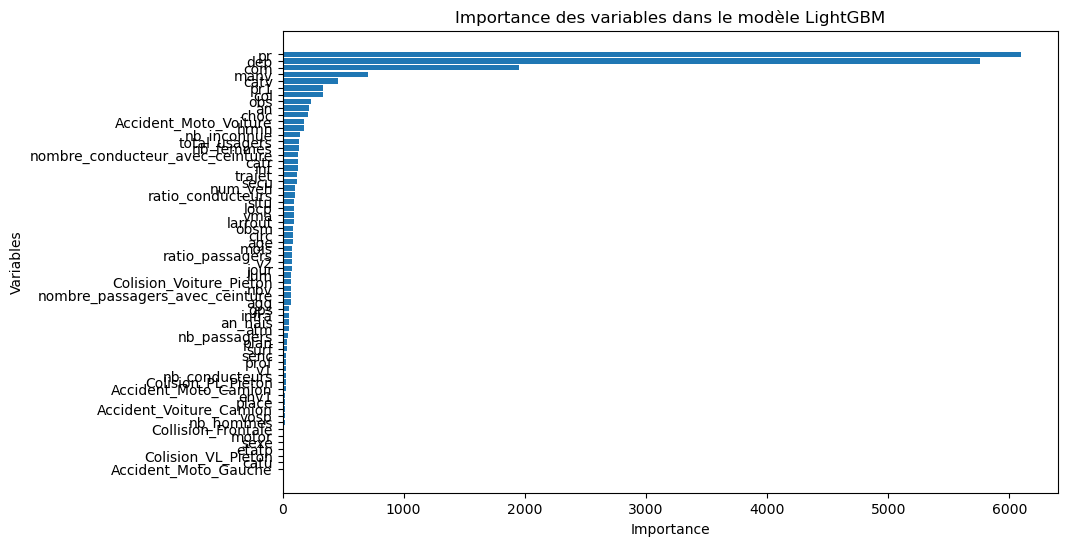

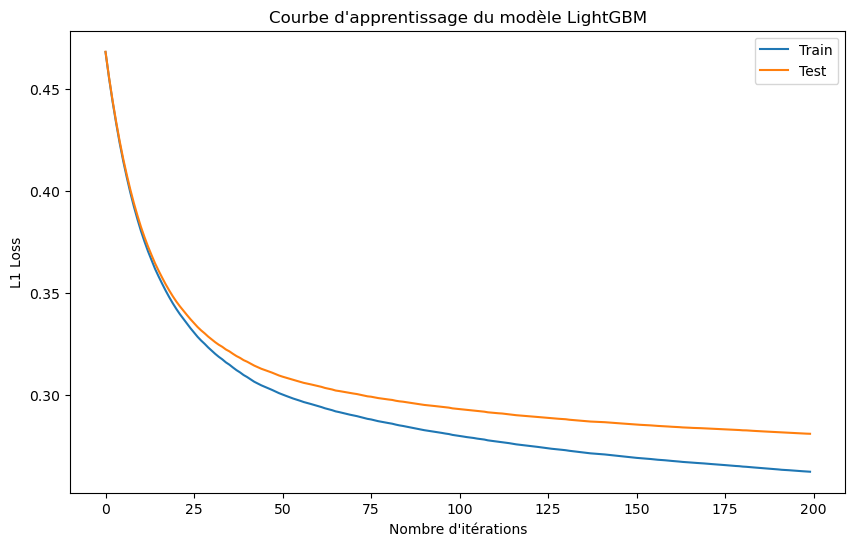

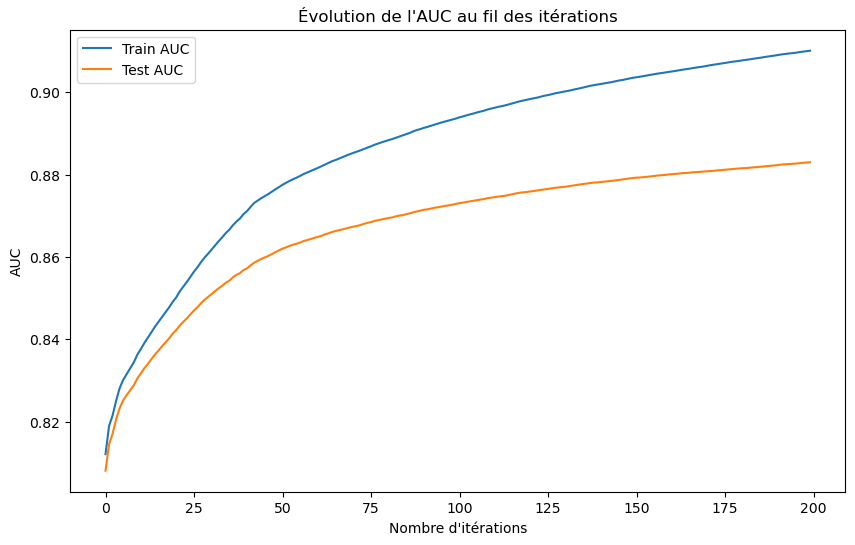

In [64]:
feature_imp_df,model = training_model(lgb_model,X,y)

## **MODELE AVEC LES MEILLEURS VARIABLES :**

In [65]:
df_clean = df.copy()

In [66]:
best_features = feature_imp_df[feature_imp_df['Importance'] > 0]

In [67]:
X = df_clean[best_features['Feature'].to_list()]
y = df_clean['GRAVE']

In [68]:
best_features.T

,5,27,25,53,49,6,24,50,16,52,55,19,47,38,46,43,0,22,31,32,36,41,13,33,15,10,51,3,37,17,42,2,18,20,59,4,44,21,26,12,35,23,40,9,11,48,8,1,39,60,56,14,28,57,7,45,62,54,30,34,61,29
Feature,pr,dep,com,manv,catv,pr1,col,obs,an,choc,Accident_Moto_Voiture,hrmn,nb_inconnue,total_usagers,nb_femmes,nombre_conducteur_avec_ceinture,catr,int,trajet,secu,num_veh,ratio_conducteurs,situ,locp,vma,larrout,obsm,circ,age,mois,ratio_passagers,v2,jour,lum,Colision_Voiture_Pieton,nbv,nombre_passagers_avec_ceinture,agg,gps,infra,an_nais,atm,nb_passagers,plan,surf,senc,prof,v1,nb_conducteurs,Colision_PL_Pieton,Accident_Moto_Camion,env1,place,Accident_Voiture_Camion,vosp,nb_hommes,Collision_Frontale,motor,sexe,etatp,Colision_VL_Pieton,catu
Importance,6093,5757,1949,707,457,335,330,233,215,212,177,174,142,140,134,128,127,124,122,120,105,99,94,93,92,91,90,84,84,82,78,75,75,72,69,67,67,66,57,56,55,54,42,38,34,30,29,29,28,28,27,24,23,22,19,17,11,6,4,3,3,2


In [69]:
lgb_model = lgb.LGBMClassifier(boosting_type = 'gbdt',objective='binary',learning_rate = 0.1,n_estimators = 200,min_child_samples = 1200,num_leaves = 100)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 364155, number of negative: 532819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7765
[LightGBM] [Info] Number of data points in the train set: 896974, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405982 -> initscore=-0.380602
[LightGBM] [Info] Start training from score -0.380602
AUC LightGBM: 0.882968580278982


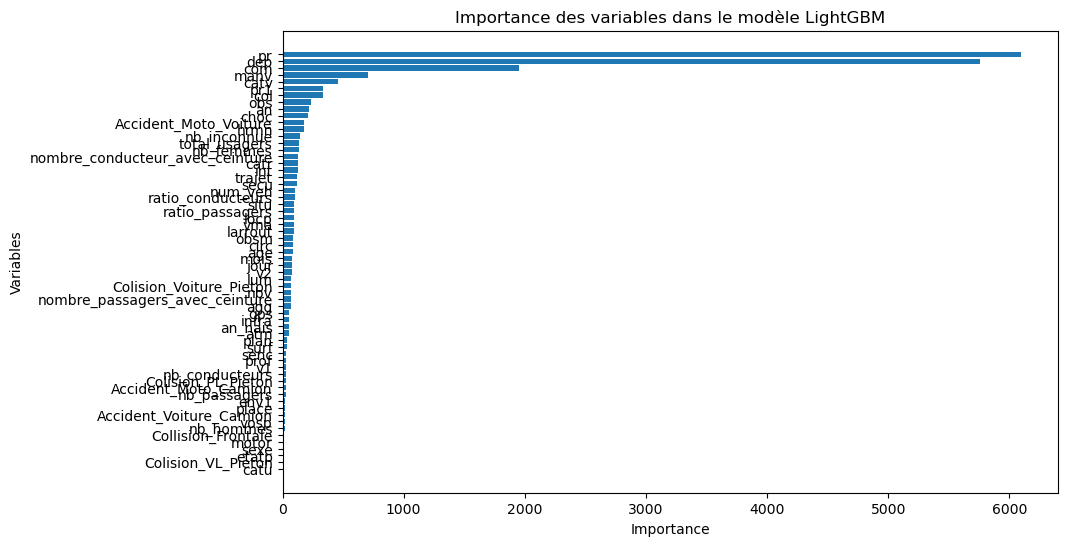

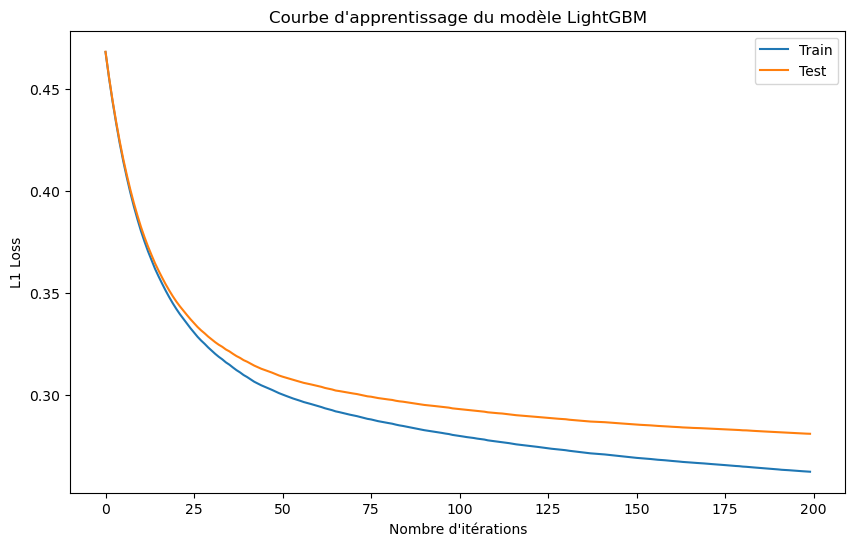

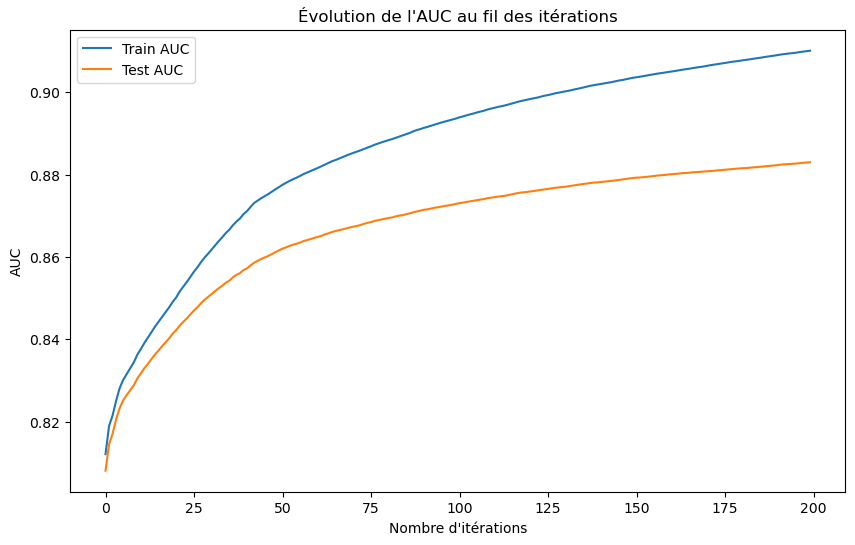

In [70]:
feature_imp_df_final,model_best_features = training_model(lgb_model,X,y)

# **PREDICTIONS :**

In [78]:
caracretistiques_test = pd.read_csv('TEST/CARACTERISTIQUES.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_22844\2856563717.py:1: DtypeWarning: Columns (4,10,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  caracretistiques_test = pd.read_csv('TEST/CARACTERISTIQUES.csv',delimiter = ',')


In [79]:
usagers_test = pd.read_csv('TEST/USAGERS.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_22844\2983500007.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  usagers_test = pd.read_csv('TEST/USAGERS.csv',delimiter = ',')


In [80]:
vehicules_test = pd.read_csv('TEST/VEHICULES.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_22844\2288480637.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicules_test = pd.read_csv('TEST/VEHICULES.csv',delimiter = ',')


In [81]:
lieux_test = pd.read_csv('TEST/LIEUX.csv',delimiter = ',')

C:\Users\lucie\AppData\Local\Temp\ipykernel_22844\471374127.py:1: DtypeWarning: Columns (7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux_test = pd.read_csv('TEST/LIEUX.csv',delimiter = ',')


In [82]:
usagers_test = feature_engineering_usagers(usagers_test)

vehicules_test = feature_engineering_vehicules(vehicules_test)

caracretistiques_test = feature_engineering_caracteristiques(caracretistiques_test)

lieux_test = feature_engineering_lieux(lieux_test)

In [83]:
df = usagers_test.merge(vehicules_test,on = ['Num_Acc','num_veh'],how  = 'left')
df['num_veh'] = df['num_veh'].astype("category")
df = caracretistiques_test.merge(df,on = 'Num_Acc',how  = 'left')
df = lieux_test.merge(df,on = 'Num_Acc',how  = 'left')

In [84]:
df = df[list_features]

In [85]:
len(list_features)

64

In [86]:
# Vérifiez si chaque élément dans list_features est une colonne dans df
missing_columns = [col for col in list_features if col not in df.columns]
extra_columns = [col for col in df.columns if col not in list_features]

print("Colonnes manquantes dans df:", missing_columns)
print("Colonnes en excès dans df:", extra_columns)

Colonnes manquantes dans df: []
Colonnes en excès dans df: []


In [87]:
# Supposons que df est votre DataFrame
column_names = df.columns

# Utiliser collections.Counter pour compter les occurrences de chaque nom de colonne
from collections import Counter
column_count = Counter(column_names)

# Filtrer pour trouver les colonnes dupliquées
duplicates = {item: count for item, count in column_count.items() if count > 1}

print("Colonnes dupliquées et leur nombre d'occurrences :")
for column, count in duplicates.items():
    print(f"{column}: {count}")

Colonnes dupliquées et leur nombre d'occurrences :


In [88]:
X = df.drop('Num_Acc',axis = 1)

In [89]:
y_pred_new = model.predict(X)
probabilities_new = model.predict_proba(X)[:, 1] 

In [90]:
results = pd.DataFrame({
    'Num_Acc': df['Num_Acc'],
    'GRAVE': probabilities_new
})

In [91]:
result = results.groupby('Num_Acc')['GRAVE'].max().reset_index()

In [92]:
result.to_csv('LIGHTGBM_ALLFEATURES_SANSAGG.csv',sep = ',', index = False)

In [93]:
X = df[best_features['Feature'].to_list()]

In [94]:
y_pred_new = model_best_features.predict(X)
probabilities_new = model_best_features.predict_proba(X)[:, 1] 

In [95]:
results = pd.DataFrame({
    'Num_Acc': df['Num_Acc'],
    'GRAVE': probabilities_new
})

In [96]:
result = results.groupby('Num_Acc')['GRAVE'].max().reset_index()

In [97]:
#result.to_csv('LIGHTGBM_BESTFEATURES_SANSAGG.csv',sep = ',', index = False)